In [1]:
# Lan Le - UB Person Number: 50322056
# CSE555 Problem Set 5: Generative Models




import os
import gzip
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import keras
from keras.layers import Lambda, Input, InputLayer, Dense, BatchNormalization, LeakyReLU, Dropout, Reshape, Flatten, Conv2D, Conv2DTranspose
from keras.models import Model, Sequential
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from scipy.special import expit
from scipy.stats import norm





def load_mnist(path, kind='train'):

    #Load MNIST data from path
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels




# read Digit MNIST dataset
base_dir = os.path.dirname('__file__')
digit_file_path = os.path.join(base_dir, 'data')

X_train, y_train = load_mnist(digit_file_path, kind='train')
X_test, y_test = load_mnist(digit_file_path, kind='t10k')

# scale input data
X_train = np.divide(X_train, 255)
X_test = np.divide(X_test, 255)

Using TensorFlow backend.


Boltzmann machines are generative deep learning models with only two types of nodes, hidden and visible nodes. Restricted Boltzmann machines (RBM) is a special type of Boltzmann machines as they limit the connections to only between hidden and visible nodes (i.e. nodes in the same group are not connected to each other). In this problem set, RBM is used to generate MNIST images using the training data set. <br>
RBM is trained by passing input features into the forward pass and then trying to reconstruct the input during the backward pass. The technique we use for training RBM here is contrastive divergence (CD). <br>
Let $x$ be the visible features and $h$ be the latent features. We have the energy over $x$ and $h$ as:
\begin{equation}
    E(x, h) = - {\sum_j {\sum_k w_{jk} h_j x_k}} - {\sum_k c_k x_k} - {\sum_j b_j h_j}
\end{equation}
where $c_k$ and $b_j$ are the biases. <br>
The probability over x and h:
\begin{equation}
    p(x, h) = exp(-E(x,h))/Z
\end{equation}
where $Z = {\sum_{x,h} exp(-E(x,h))}$. <br>
Therefore:
\begin{equation}
    p(x) = {\sum_h p(x,h)} = {\sum_h exp(-E(x,h))/Z}
\end{equation}
Markov structure of an RBM:
\begin{align}
    p(h|x) &= {\prod_j p(h_j|x)} \\
    p(h_j = 1|x) &= \sigma (b_j + W_j x) \\
    p(x|h) &= {\prod_k p(x_k|h)} \\
    p(x_k = 1|h) &= \sigma (c_k + h^T W_k) \\
\end{align}
The log likelihood of x:
\begin{equation}
    log\;p(x) = log\;{\sum_h exp(-E(x,h))/Z} = log {\sum_h exp(-E(x,h))} - log {\sum_{x,h} exp(-E(x,h))}
\end{equation}
From there, we have the derivative of log probability of $x$ with respect to weight $w$:
\begin{align}
    \frac{\delta log\;p(x)}{\delta w_{jk}} &= \frac{\delta}{\delta w_{jk}} (log {\sum_h exp(-E(x,h))} - \frac{\delta}{\delta w_{jk}} (log {\sum_{x,h} exp(-E(x,h))} \\
    &= - \frac{1}{{\sum_h exp(-E(x,h))}} {\sum_h exp(-E(x,h))} \frac{\delta E(x,h)}{\delta w_{jk}} + \frac{1}{{\sum_{x,h} exp(-E(x,h))}} {\sum_{x,h} exp(-E(x,h))} \frac{\delta E(x,h)}{\delta w_{jk}} \\
    &= - {\sum_h p(h|x) \frac{\delta E(x,h)}{\delta w_{jk}}} + {\sum_{x,h} p(x,h) \frac{\delta E(x,h)}{\delta w_{jk}}} \\
    &= {\sum_h p(h|x) h_j x_k} - {\sum_x p(x)} {\sum_h p(h|x) h_j x_k} \\
    &= p(h_j = 1|x) x_k - {\sum_x p(x) p(h_j = 1|x) x_k} \\
\end{align}
Similarly, we get the derivatives with respect to the bias parameters:
\begin{align}
    \frac{\delta log(x)}{\delta c_k} = x_k - {\sum_x p(x) x_k} \\
    \frac{\delta log(x)}{\delta b_j} = p(h_j = 1|x) - {\sum_x p(x) p(h_j = 1|x)}
\end{align}
Using t-step CD, we have the update rule:
\begin{align}
    \Delta w_{jk} &= \Delta w_{jk} + p(h_j = 1|x^{(0)}) {x_k}^{(0)} - p(h_j = 1|x^{(t)}) {x_k}^{(t)} \\
    \Delta c_k &= \Delta c_k + {x_k}^{(0)} - {x_k}^{(t)}\\
    \Delta b_j &= \Delta b_j + p(h_j = 1|x^{(0)}) - p(h_j = 1|x^{(t)}) \\
\end{align}

Generate new images using training data set


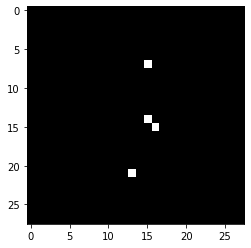

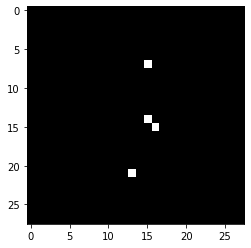

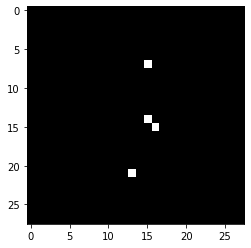

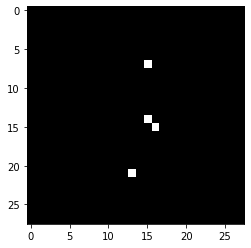

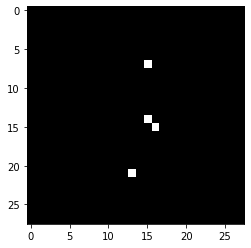

Generate new images using testing data set that have 20% pixels missing


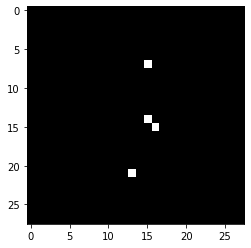

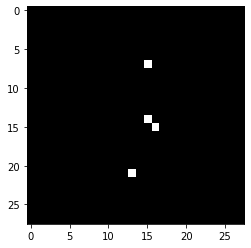

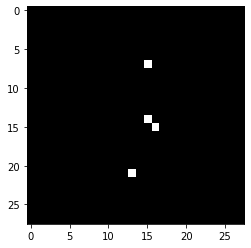

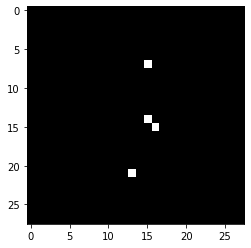

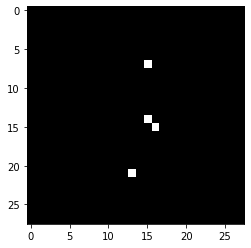

Generate new images using testing data set that have 50% pixels missing


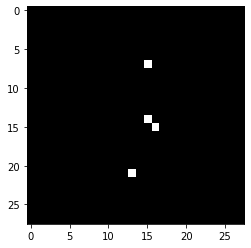

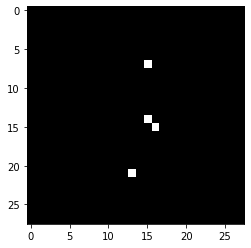

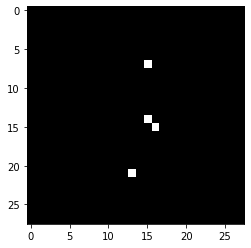

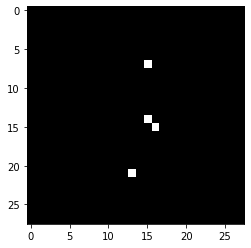

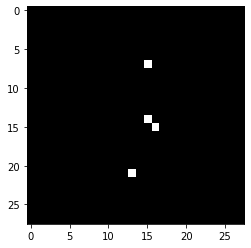

Generate new images using testing data set that have 80% pixels missing


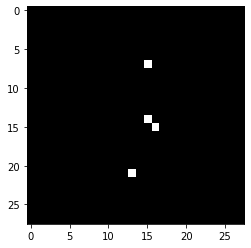

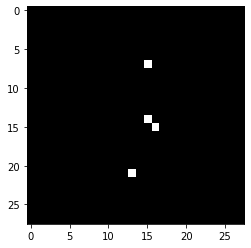

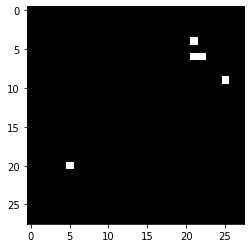

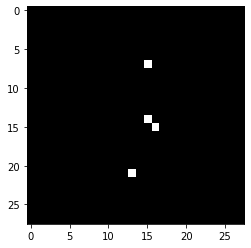

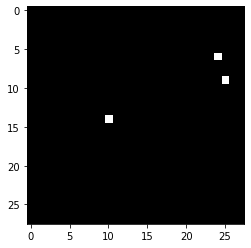

In [2]:
# RBM


# remove pixels from image
def remove_pixel(img, ratio):
    num_pixels = img.shape[0]
    num_remove = int(num_pixels * ratio)
    index_remove = random.sample(range(num_pixels), num_remove)
    img[index_remove] = 0
    
    return img


# training with RBM
def rbm(dataset, num_hidden_nodes, learning_rate, epochs, batch_size):
    num_visible_nodes = dataset.shape[1]
    num_imgs = dataset.shape[0]
    
    batches = int(num_imgs / batch_size)
    
    # initialize weights and biases
    w = 0.1 * np.random.randn(num_visible_nodes, num_hidden_nodes)
    c = np.zeros((1, num_visible_nodes))
    b = np.zeros((1, num_hidden_nodes))
    
    delta_w = np.zeros((num_visible_nodes, num_hidden_nodes))
    delta_c = np.zeros((1, num_visible_nodes))
    delta_b = np.zeros((1, num_hidden_nodes))
    
    for epoch in range(epochs):
        for batch in range(batches):
            # positive phase/forward pass
            x0 = dataset[batch_size*batch:batch_size*(batch+1)]
            p_h0 = expit(np.matmul(x0, w) + b)
            h0 = p_h0 > np.random.rand(batch_size, num_hidden_nodes)
            pos_phase = np.matmul(np.transpose(x0), p_h0)
            
            # negative phase/backward pass
            x1 = expit(np.matmul(h0, np.transpose(w)) + c)
            p_h1 = expit(np.matmul(x1, w) + b)
            neg_phase = np.matmul(np.transpose(x1), p_h1)
            
            # update weights and biases
            delta_w = delta_w + learning_rate * (pos_phase - neg_phase)
            delta_c = delta_c + learning_rate * (np.sum(x0) - np.sum(x1))
            delta_b = delta_b + learning_rate * (np.sum(p_h0) - np.sum(p_h1))
            
            w = w + delta_w
            c = c + delta_c
            b = b + delta_b
            
    return w, c, b


def reconstruct(x0, w, c, b):
    num_hidden_nodes = w.shape[1]
    p_h0 = expit(np.matmul(x0, w) + b)
    h0 = p_h0 > np.random.rand(1, num_hidden_nodes)

    return expit(np.matmul(h0, np.transpose(w)) + c)




# sample images used to generate new images
train_imgs = X_train[:5]
test_imgs = X_test[:5]

# train RBM with 20 hidden nodes
w, c, b = rbm(X_train, 20, 0.1, 100, 100)

# generate MNIST images using training data set
print('Generate new images using training data set')
for i in range(5):
    org_img = train_imgs[i]
    recon_img = reconstruct(org_img, w, c, b)
    recon_img = np.reshape(recon_img, (28, 28))
    plt.imshow(recon_img, cmap = 'gray')
    plt.show()

# generate MNIST images using testing data set that have 20% pixels missing/removed
print('Generate new images using testing data set that have 20% pixels missing')
for i in range(5):
    org_img = remove_pixel(test_imgs[i], 0.2)
    recon_img = reconstruct(org_img, w, c, b)
    recon_img = np.reshape(recon_img, (28, 28))
    plt.imshow(recon_img, cmap = 'gray')
    plt.show()

# generate MNIST images using testing data set that have 50% pixels missing/removed
print('Generate new images using testing data set that have 50% pixels missing')
for i in range(5):
    org_img = remove_pixel(test_imgs[i], 0.5)
    recon_img = reconstruct(org_img, w, c, b)
    recon_img = np.reshape(recon_img, (28, 28))
    plt.imshow(recon_img, cmap = 'gray')
    plt.show()

# generate MNIST images using testing data set that have 80% pixels missing/removed
print('Generate new images using testing data set that have 80% pixels missing')
for i in range(5):
    org_img = remove_pixel(test_imgs[i], 0.8)
    recon_img = reconstruct(org_img, w, c, b)
    recon_img = np.reshape(recon_img, (28, 28))
    plt.imshow(recon_img, cmap = 'gray')
    plt.show()

Generate new images using training data set


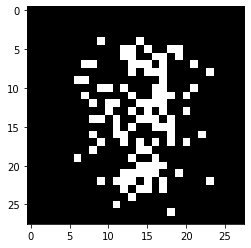

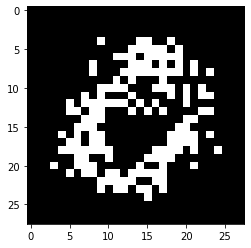

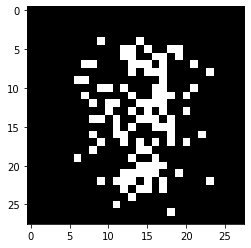

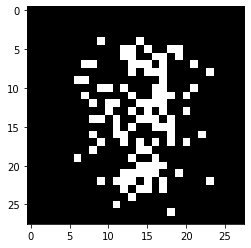

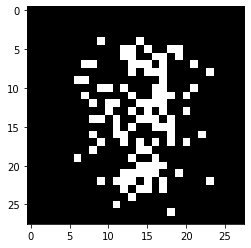

Generate new images using testing data set that have 20% pixels missing


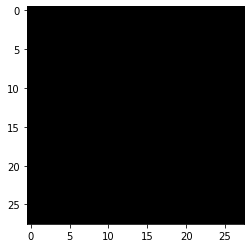

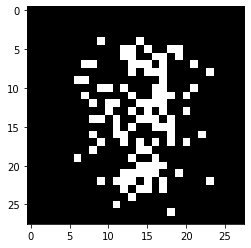

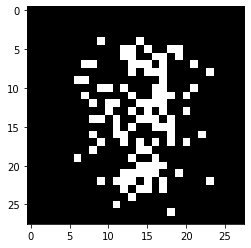

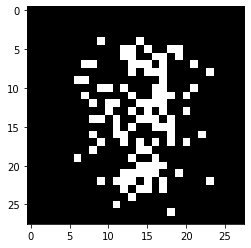

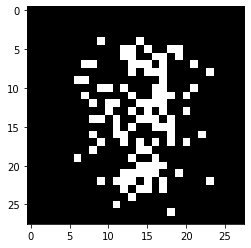

Generate new images using testing data set that have 50% pixels missing


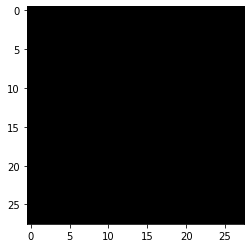

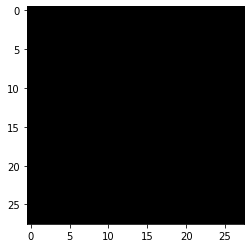

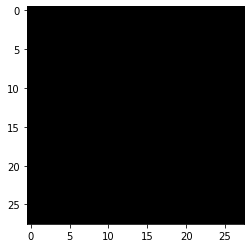

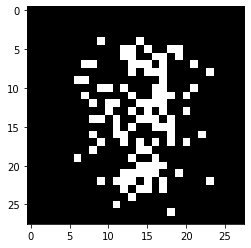

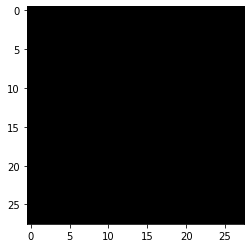

Generate new images using testing data set that have 80% pixels missing


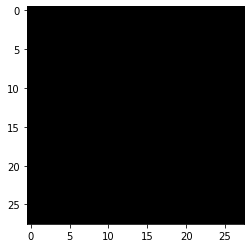

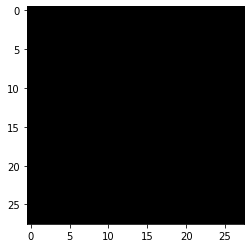

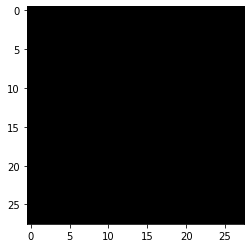

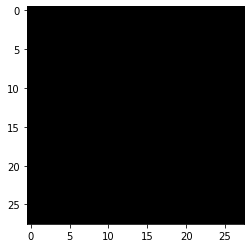

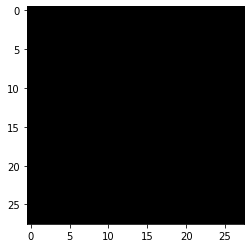

In [3]:
# train RBM with 50 hidden nodes
w, c, b = rbm(X_train, 50, 0.1, 100, 100)

# generate MNIST images using training data set
print('Generate new images using training data set')
for i in range(5):
    org_img = train_imgs[i]
    recon_img = reconstruct(org_img, w, c, b)
    recon_img = np.reshape(recon_img, (28, 28))
    plt.imshow(recon_img, cmap = 'gray')
    plt.show()

# generate MNIST images using testing data set that have 20% pixels missing/removed
print('Generate new images using testing data set that have 20% pixels missing')
for i in range(5):
    org_img = remove_pixel(test_imgs[i], 0.2)
    recon_img = reconstruct(org_img, w, c, b)
    recon_img = np.reshape(recon_img, (28, 28))
    plt.imshow(recon_img, cmap = 'gray')
    plt.show()

# generate MNIST images using testing data set that have 50% pixels missing/removed
print('Generate new images using testing data set that have 50% pixels missing')
for i in range(5):
    org_img = remove_pixel(test_imgs[i], 0.5)
    recon_img = reconstruct(org_img, w, c, b)
    recon_img = np.reshape(recon_img, (28, 28))
    plt.imshow(recon_img, cmap = 'gray')
    plt.show()

# generate MNIST images using testing data set that have 80% pixels missing/removed
print('Generate new images using testing data set that have 80% pixels missing')
for i in range(5):
    org_img = remove_pixel(test_imgs[i], 0.8)
    recon_img = reconstruct(org_img, w, c, b)
    recon_img = np.reshape(recon_img, (28, 28))
    plt.imshow(recon_img, cmap = 'gray')
    plt.show()

Generate new images using training data set


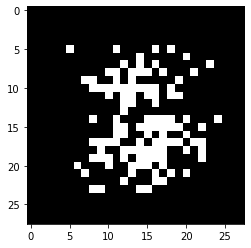

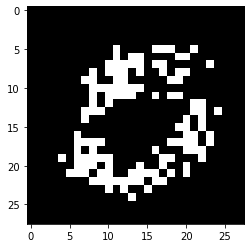

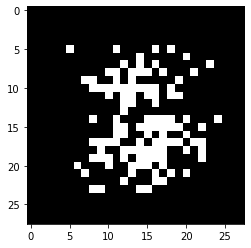

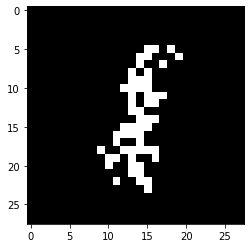

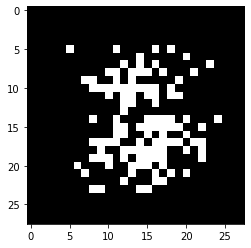

Generate new images using testing data set that have 20% pixels missing


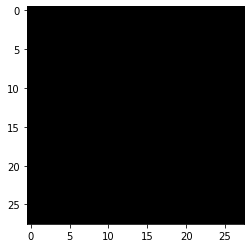

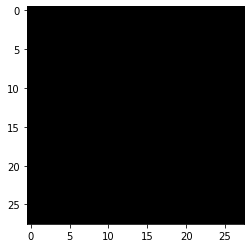

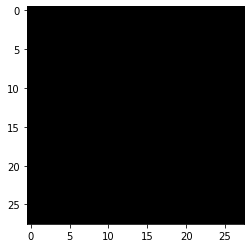

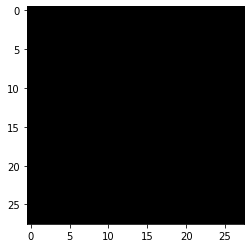

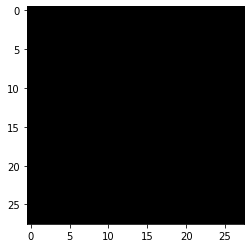

Generate new images using testing data set that have 50% pixels missing


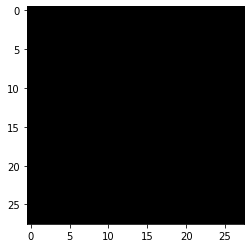

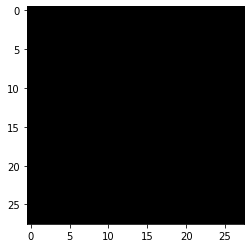

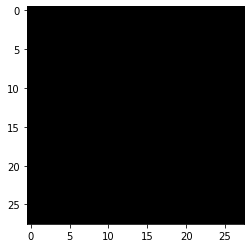

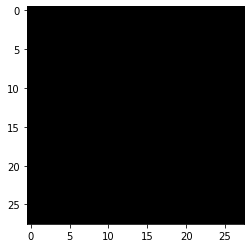

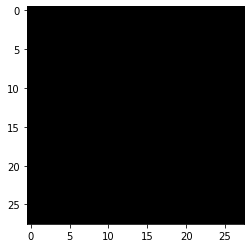

Generate new images using testing data set that have 80% pixels missing


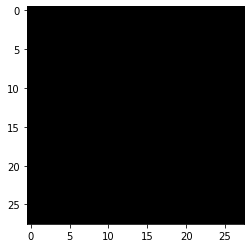

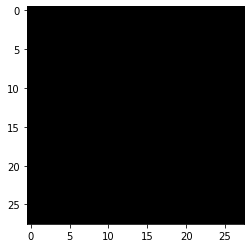

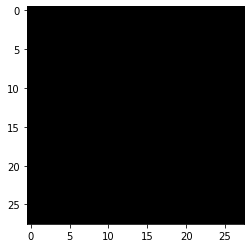

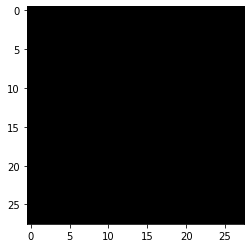

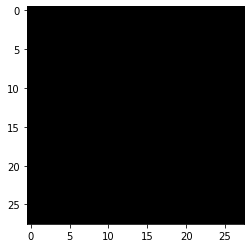

In [4]:
# train RBM with 100 hidden nodes
w, c, b = rbm(X_train, 100, 0.1, 100, 100)

# generate MNIST images using training data set
print('Generate new images using training data set')
for i in range(5):
    org_img = train_imgs[i]
    recon_img = reconstruct(org_img, w, c, b)
    recon_img = np.reshape(recon_img, (28, 28))
    plt.imshow(recon_img, cmap = 'gray')
    plt.show()

# generate MNIST images using testing data set that have 20% pixels missing/removed
print('Generate new images using testing data set that have 20% pixels missing')
for i in range(5):
    org_img = remove_pixel(test_imgs[i], 0.2)
    recon_img = reconstruct(org_img, w, c, b)
    recon_img = np.reshape(recon_img, (28, 28))
    plt.imshow(recon_img, cmap = 'gray')
    plt.show()

# generate MNIST images using testing data set that have 50% pixels missing/removed
print('Generate new images using testing data set that have 50% pixels missing')
for i in range(5):
    org_img = remove_pixel(test_imgs[i], 0.5)
    recon_img = reconstruct(org_img, w, c, b)
    recon_img = np.reshape(recon_img, (28, 28))
    plt.imshow(recon_img, cmap = 'gray')
    plt.show()

# generate MNIST images using testing data set that have 80% pixels missing/removed
print('Generate new images using testing data set that have 80% pixels missing')
for i in range(5):
    org_img = remove_pixel(test_imgs[i], 0.8)
    recon_img = reconstruct(org_img, w, c, b)
    recon_img = np.reshape(recon_img, (28, 28))
    plt.imshow(recon_img, cmap = 'gray')
    plt.show()

Variational autoencoder (VAE) is an autoencoder whose encoding distribution is regularized during the training in order to ensure that its latent space has good properties allowing us to generate new data. Instead of producing a vector like standard autoencoders, VAE models a distribution as the encoder's output. The distribution is sampled during the forward pass. The backpropagation is then allowed with the use of reparameterization. <br>
Let $x$ be the training data and $z$ be the latent variables. Our goal is to determine the posterior distribution $p(z|x)$. However, determining this posterior distribution is typically computationally intractable. Therefore, instead we approximate the posterior with a distribution $q(z|x)$ and minimize the difference between the true posterior and the approximation using Kullback-Leibler Divergence.
\begin{align}
    D_{KL} (q(z|x) || p(z|x)) &= \int q(z|x) log\,(\frac{q(z|x)}{p(z|x)}) dz \\
    &= - \int q(z|x) log\,(\frac{p(z|x)}{q(z|x)}) dz
\end{align}
Applying Bayes' theorem to the above equation:
\begin{align}
    D_{KL} (q_{\phi} (z|x^{(i)}) || p_{\theta} (z|x^{(i)})) &= - \int q_{\phi} (z|x^{(i)}) log(\frac{p_{\phi} (x^{(i)}|z) p_{\theta} (z)}{q_{\phi} (z|x^{(i)}) p_{\theta} (x^{(i)})}) dz \geqslant 0 \\
    &= - \int q_{\phi} (z|x^{(i)}) log(\frac{p_{\theta} (x^{(i)}|z) p_{\theta} (z)}{q_{\phi} (z|x^{(i)})}) dz + \int q_{\phi} (z|x^{(i)}) log(p_{\theta} (x^{(i)})) dz \geqslant 0 \\
    &= - \int q_{\phi} (z|x^{(i)}) log(\frac{p_{\phi} (x^{(i)}|z) p_{\theta} (z)}{q_{\phi} (z|x^{(i)})}) dz + log(p_{\theta} (x^{(i)})) \geqslant 0 \\
\end{align}
With further manipulation, we have:
\begin{align}
    log(p_{\theta} (x^{(i)})) &\geqslant \int q_{\phi} (z|x^{(i)}) log(\frac{p_{\theta} (z)}{q_{\phi} (z|x^{(i)})}) dz + \int q_{\phi} (z|x^{(i)}) log(p_{\theta} (x^{(i)}|z)) dz \\
    &\geqslant -D_{KL} (q_{\phi} (z|x^{(i)} || p_{\theta} (z)) + E_{q_{\phi} (z|x^{(i)}} log(p_{\theta} (x^{(i)}|z)) \\
\end{align}
The right hand side of the above equation is the variational lower bound. Our goal is to maximize the variational lower bound with gradient ascent. <br>
We assume $q(z|x)$ to be Gaussian distribution with mean $\mu (x)$ and variance $\Sigma (x)$ and choose $p(z)$ to be $N(0,1)$. As a result, we have the following form for KL Divergence.
\begin{equation}
    D_{KL} (N(\mu (x), \Sigma (x))||N(0,1)) = \frac{1}{2} {\sum_k (\Sigma (x) + \mu^2 (x) - 1 - log \Sigma (x))}
\end{equation}

Epoch 1/10
60000/60000 [==============================] - 10s 168us/step - loss: 205.3830
Epoch 2/10
60000/60000 [==============================] - 7s 124us/step - loss: 171.1103
Epoch 3/10
60000/60000 [==============================] - 7s 123us/step - loss: 166.6423
Epoch 4/10
60000/60000 [==============================] - 7s 118us/step - loss: 164.6656
Epoch 5/10
60000/60000 [==============================] - 7s 114us/step - loss: 163.1228
Epoch 6/10
60000/60000 [==============================] - 8s 127us/step - loss: 161.8159
Epoch 7/10
60000/60000 [==============================] - 8s 131us/step - loss: 160.6921
Epoch 8/10
60000/60000 [==============================] - 7s 120us/step - loss: 159.7254
Epoch 9/10
60000/60000 [==============================] - 7s 122us/step - loss: 158.7753
Epoch 10/10
60000/60000 [==============================] - 8s 130us/step - loss: 157.9754


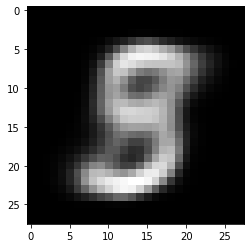

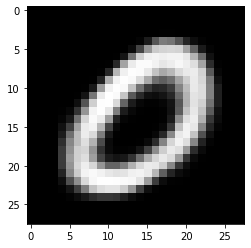

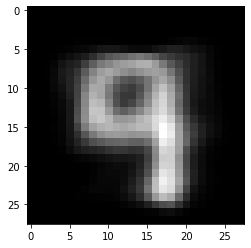

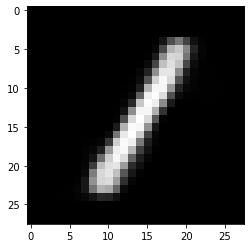

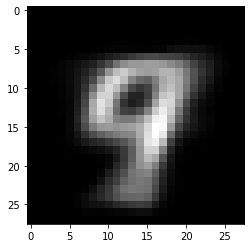

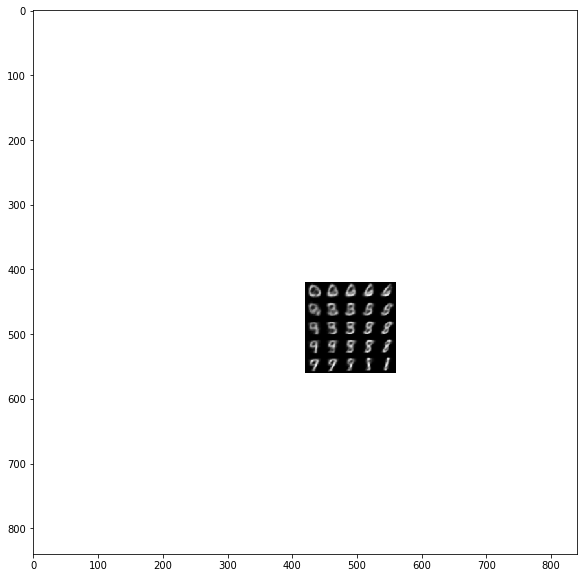

In [5]:
# VAE with MNN


# reparameterization trick
def sample_z(args):
    z_mean, z_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    eps = K.random_normal(shape=(batch, dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_var) * eps


# define the loss function (reconstruction and KL)
def vae_loss(y_pred, y_true):
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    kl = -0.5 * K.sum(1 + z_var - K.square(z_mean) - K.exp(z_var), axis=1)

    return (recon + kl)




# initialize parameters
batch_size = 128
epochs = 10

train_imgs = X_train[:5]

# train VAE with 2 code units
latent_dim = 2

# build encoder model
inputs = Input(shape=(X_train.shape[1:]))
he = Dense(256, activation='relu')(inputs)
z_mean = Dense(latent_dim)(he)
z_var = Dense(latent_dim)(he)

# use reparameterization trick
z = Lambda(sample_z, output_shape=(latent_dim,))([z_mean, z_var])

encoder = Model(inputs, [z_mean, z_var, z])

# build decoder model
latent_inputs = Input(shape=(latent_dim,))
hd = Dense(256, activation='relu')(latent_inputs)
outputs = Dense(784, activation='sigmoid')(hd)

decoder = Model(latent_inputs, outputs)

# create VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs)
vae.compile(optimizer='adam', loss=vae_loss)
vae.fit(X_train, X_train, batch_size=batch_size, epochs=epochs)

# generate new images using training data set
gen_imgs = vae.predict(train_imgs)

for i in range(5):
    gen_img = gen_imgs[i]
    gen_img = np.reshape(gen_img, (28, 28))
    plt.imshow(gen_img, cmap = 'gray')
    plt.show()

# generate images by varying each code unit from -3 to 3
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

x_axis = norm.ppf(np.linspace(-3, 3, n)) 
y_axis = norm.ppf(np.linspace(-3, 3, n))

for i, yi in enumerate(x_axis):
    for j, xi in enumerate(y_axis):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.show()

Epoch 1/10
60000/60000 [==============================] - 8s 130us/step - loss: 188.9658
Epoch 2/10
60000/60000 [==============================] - 8s 127us/step - loss: 152.7414
Epoch 3/10
60000/60000 [==============================] - 8s 130us/step - loss: 146.0729
Epoch 4/10
60000/60000 [==============================] - 7s 120us/step - loss: 142.9844
Epoch 5/10
60000/60000 [==============================] - 7s 121us/step - loss: 141.0256
Epoch 6/10
60000/60000 [==============================] - 8s 127us/step - loss: 139.5682
Epoch 7/10
60000/60000 [==============================] - 8s 130us/step - loss: 138.3917
Epoch 8/10
60000/60000 [==============================] - 8s 138us/step - loss: 137.3587
Epoch 9/10
60000/60000 [==============================] - 8s 128us/step - loss: 136.4598
Epoch 10/10
60000/60000 [==============================] - 8s 139us/step - loss: 135.6450


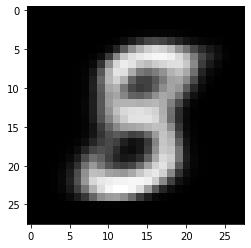

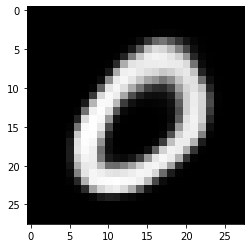

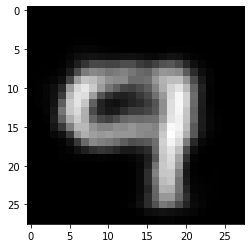

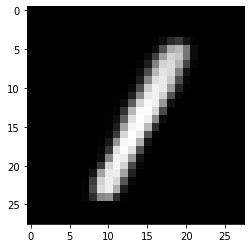

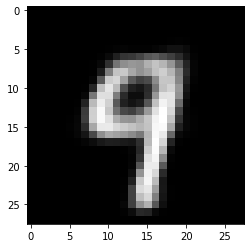

In [6]:
# train VAE with 4 code units
latent_dim = 4

# build encoder model
inputs = Input(shape=(784,))
he = Dense(256, activation='relu')(inputs)
z_mean = Dense(latent_dim)(he)
z_var = Dense(latent_dim)(he)

# use reparameterization trick
z = Lambda(sample_z, output_shape=(latent_dim,))([z_mean, z_var])

encoder = Model(inputs, [z_mean, z_var, z])

# build decoder model
latent_inputs = Input(shape=(latent_dim,))
hd = Dense(256, activation='relu')(latent_inputs)
outputs = Dense(784, activation='sigmoid')(hd)

decoder = Model(latent_inputs, outputs)

# create VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs)
vae.compile(optimizer='adam', loss=vae_loss)
vae.fit(X_train, X_train, batch_size=batch_size, epochs=epochs)

# generate new images using training data set
gen_imgs = vae.predict(train_imgs)

for i in range(5):
    gen_img = gen_imgs[i]
    gen_img = np.reshape(gen_img, (28, 28))
    plt.imshow(gen_img, cmap = 'gray')
    plt.show()

Epoch 1/10
60000/60000 [==============================] - 7s 122us/step - loss: 178.0296
Epoch 2/10
60000/60000 [==============================] - 7s 124us/step - loss: 140.0307
Epoch 3/10
60000/60000 [==============================] - 7s 120us/step - loss: 134.4871
Epoch 4/10
60000/60000 [==============================] - 7s 117us/step - loss: 131.4029
Epoch 5/10
60000/60000 [==============================] - 7s 119us/step - loss: 129.4860
Epoch 6/10
60000/60000 [==============================] - 7s 116us/step - loss: 128.1261
Epoch 7/10
60000/60000 [==============================] - 7s 116us/step - loss: 127.0991
Epoch 8/10
60000/60000 [==============================] - 9s 150us/step - loss: 126.2182
Epoch 9/10
60000/60000 [==============================] - 7s 121us/step - loss: 125.4026
Epoch 10/10
60000/60000 [==============================] - 11s 181us/step - loss: 124.6773


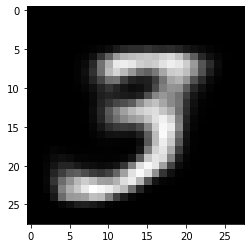

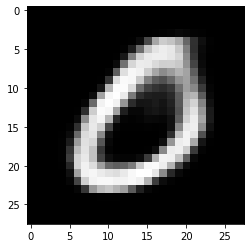

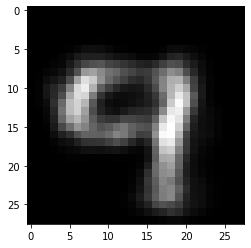

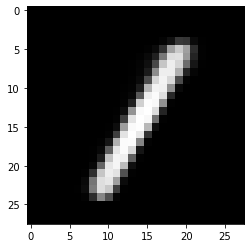

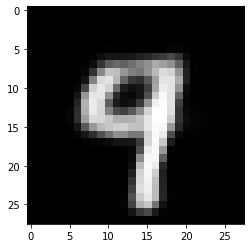

In [7]:
# train VAE with 6 code units
latent_dim = 6

# build encoder model
inputs = Input(shape=(784,))
he = Dense(256, activation='relu')(inputs)
z_mean = Dense(latent_dim)(he)
z_var = Dense(latent_dim)(he)

# use reparameterization trick
z = Lambda(sample_z, output_shape=(latent_dim,))([z_mean, z_var])

encoder = Model(inputs, [z_mean, z_var, z])

# build decoder model
latent_inputs = Input(shape=(latent_dim,))
hd = Dense(256, activation='relu')(latent_inputs)
outputs = Dense(784, activation='sigmoid')(hd)

decoder = Model(latent_inputs, outputs)

# create VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs)
vae.compile(optimizer='adam', loss=vae_loss)
vae.fit(X_train, X_train, batch_size=batch_size, epochs=epochs)

# generate new images using training data set
gen_imgs = vae.predict(train_imgs)

for i in range(5):
    gen_img = gen_imgs[i]
    gen_img = np.reshape(gen_img, (28, 28))
    plt.imshow(gen_img, cmap = 'gray')
    plt.show()

Epoch 1/10
60000/60000 [==============================] - 28s 458us/step - loss: 8.9138
Epoch 2/10
60000/60000 [==============================] - 27s 454us/step - loss: 7.4123
Epoch 3/10
60000/60000 [==============================] - 27s 444us/step - loss: 7.3815
Epoch 4/10
60000/60000 [==============================] - 27s 456us/step - loss: 7.3735
Epoch 5/10
60000/60000 [==============================] - 27s 450us/step - loss: 7.3696
Epoch 6/10
60000/60000 [==============================] - 27s 447us/step - loss: 7.3669
Epoch 7/10
60000/60000 [==============================] - 27s 452us/step - loss: 7.3662
Epoch 8/10
60000/60000 [==============================] - 28s 460us/step - loss: 7.3643
Epoch 9/10
60000/60000 [==============================] - 27s 454us/step - loss: 7.3637
Epoch 10/10
60000/60000 [==============================] - 29s 476us/step - loss: 7.3633


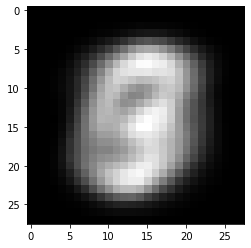

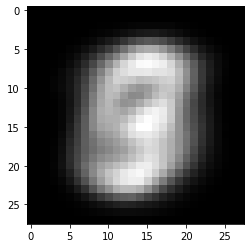

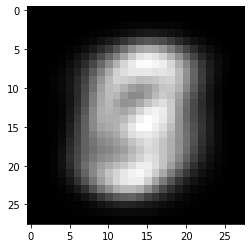

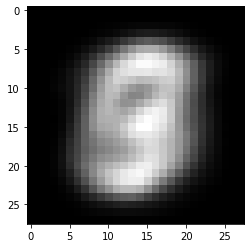

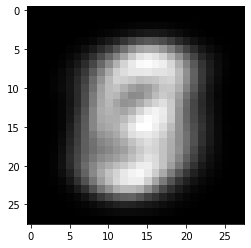

In [13]:
# VAE with CNN

latent_dim = 2

# reshape images
X_train = np.reshape(X_train, (-1, 28, 28, 1))

# build encoder model
inputs = Input(shape=(28, 28, 1))
conv_x = Conv2D(filters=8, kernel_size=3, strides=2, 
                padding='same', activation='relu')(inputs)
conv_x = Conv2D(filters=16, kernel_size=3, strides=2, 
                padding='same', activation='relu')(conv_x)
x = Flatten()(conv_x)
x = Dense(4, activation='relu')(x)
z_mean = Dense(latent_dim)(x)
z_var = Dense(latent_dim)(x)

conv_shape = K.int_shape(conv_x)

# use reparameterization trick
z = Lambda(sample_z, output_shape=(latent_dim,))([z_mean, z_var])

encoder = Model(inputs, [z_mean, z_var, z])

# build decoder model
latent_inputs = Input(shape=(2,))
x = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(latent_inputs)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
deconv_x = Conv2DTranspose(filters=16, kernel_size=3, strides=2, 
            padding='same', activation='relu')(x)
deconv_x = Conv2DTranspose(filters=8, kernel_size=3, strides=2, 
            padding='same', activation='relu')(deconv_x)
outputs = Conv2DTranspose(filters=1, kernel_size=3, 
                          activation='sigmoid', padding='same')(deconv_x)

decoder = Model(latent_inputs, outputs)

# create VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs)
vae.compile(optimizer='adam', loss=vae_loss)
vae.fit(X_train, X_train, batch_size=batch_size, epochs=epochs)

# generate new images using training data set
train_imgs = X_train[:5]
gen_imgs = vae.predict(train_imgs)

for i in range(5):
    gen_img = gen_imgs[i]
    gen_img = np.reshape(gen_img, (28, 28))
    plt.imshow(gen_img, cmap = 'gray')
    plt.show()

Generative adversarial network (GAN) comprises of two models: a generative model (generator) and a discriminative model (discriminator). The job of the discriminator is distinguishing between actual and generated data. Meanwhile, the generator's task is generating new data that is classified by the discriminator as actual data. During GAN training, the two models both get better at their respective tasks as they compete with each other. <br>
The loss function of GAN is called the minimax loss which is derived from the formula of binary cross-entropy loss:
\begin{equation}
    L = min_G max_D (log(D(x)) + log(1 - D(G(z))))
\end{equation}
Minibatch stochastic gradient descent training is applied to GAN. Generally, the training can be divided into 2 main steps. First, we update the discriminator by ascending its stochastic gradient:
\begin{equation}
    \Delta_{\theta_d} \frac{1}{m} {\sum_{i=1}^m log(D(x^{(i)})) + log(1 - D(G(z^{(i)})))}
\end{equation}
After that, we update the generator by descending its stochastic gradient:
\begin{equation}
    \Delta_{\theta_g} \frac{1}{m} {\sum_{i=1}^m log(1 - D(G(z^{(i)})))}
\end{equation}
where m is the number of noise samples.


100%|██████████| 234/234 [12:36<00:00,  3.23s/it]


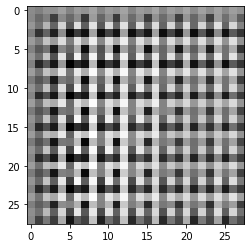

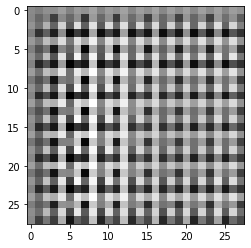

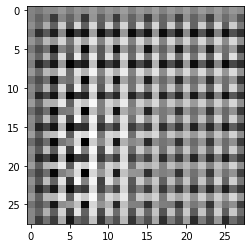

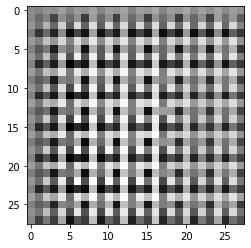

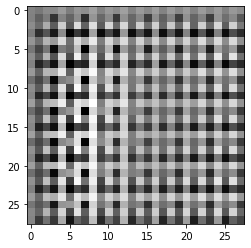

In [16]:
# GAN

# initialize optimizer
adam = Adam(learning_rate=0.0002)

# create generator
generator = Sequential()
generator.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

generator.add(Reshape((7, 7, 256)))

generator.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', 
                              use_bias=False))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', 
                              use_bias=False))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

generator.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', 
                              use_bias=False, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)

# create discriminator
discriminator = Sequential()
discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=(28, 28, 1)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.2))

discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.2))

discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

# combine generator and discriminator
discriminator.trainable=False
gan_input = Input(shape=(100,))
hidden = generator(gan_input)
gan_output= discriminator(hidden)
gan = Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer=adam)

# define the training loop
EPOCHS = 1
BATCH_SIZE = 256
batch_count = int(X_train.shape[0] / BATCH_SIZE)

for e in range(EPOCHS):
    for b in tqdm(range(batch_count)):
        # get a random set of input noise and images
        noise = np.random.normal(0, 1, size=[BATCH_SIZE, 100])
        image_batch = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)]
        image_batch = image_batch.reshape(image_batch.shape[0], image_batch.shape[1], image_batch.shape[2], 1)
        
        # generate fake MNIST images
        generated_images = generator.predict(noise)
        X = np.concatenate((image_batch, generated_images))

        # labels for generated and real data
        y1 = np.zeros(2*BATCH_SIZE)
        y1[:BATCH_SIZE] = 0.9

        # train discriminator
        discriminator.trainable = True
        discriminator.train_on_batch(X, y1)

        # train generator
        noise = np.random.normal(0, 1, size=[BATCH_SIZE, 100])
        y2 = np.ones(BATCH_SIZE)
        discriminator.trainable = False
        gan.train_on_batch(noise, y2)
        
# generate new images
noise = np.random.normal(0, 1, size=[5, 100])
gen_imgs = generator.predict(noise)
gen_imgs = np.reshape(gen_imgs, (5, 28, 28))

for i in range(5):
    gen_img = gen_imgs[i]
    plt.imshow(gen_img, cmap = 'gray')
    plt.show()